In [97]:
import torch

import triton
import triton.language as tl
from triton.runtime import driver

In [98]:
@triton.jit
def softmax_kernel_direct(input_ptr, output_ptr, stride, n_cols, BLOCK_SIZE:tl.constexpr):
    row = tl.program_id(0)
    offsets = tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_cols
    input_ptrs = input_ptr + row * stride + offsets
    x = tl.load(input_ptrs, mask=mask, other=-float('inf'))
    x_max = tl.max(x)
    x_minus_max = x - x_max
    x_exp = tl.exp(x_minus_max)
    # x_exp = x_exp * x_exp
    x_exp_sum = tl.sum(x_exp)
    output = x_exp / x_exp_sum
    output_ptrs = output_ptr + row * stride + offsets
    tl.store(output_ptrs, output, mask=mask)
    

In [99]:



def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"


def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908')


def naive_softmax(x):
    """Compute row-wise softmax of X using native pytorch

    We subtract the maximum element in order to avoid overflows. Softmax is invariant to
    this shift.
    """
    # read  MN elements ; write M  elements
    x_max = x.max(dim=1)[0]
    # read MN + M elements ; write MN elements
    z = x - x_max[:, None]
    # read  MN elements ; write MN elements
    numerator = torch.exp(z)
    # read  MN elements ; write M  elements
    denominator = numerator.sum(dim=1)
    # read MN + M elements ; write MN elements
    ret = numerator / denominator[:, None]
    # in total: read 5MN + 2M elements ; wrote 3MN + 2M elements
    return ret

In [100]:
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr,
                   num_stages: tl.constexpr):
    # starting row of the program
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        # The stride represents how much we need to increase the pointer to advance 1 row
        row_start_ptr = input_ptr + row_idx * input_row_stride
        # The block size is the next power of two greater than n_cols, so we can fit each
        # row in a single block
        col_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = row_start_ptr + col_offsets
        # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
        mask = col_offsets < n_cols
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        # Subtract maximum for numerical stability
        row_minus_max = row - tl.max(row, axis=0)
        # Note that exponentiation in Triton is fast but approximate (i.e., think __expf in CUDA)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0)
        softmax_output = numerator / denominator
        # Write back output to DRAM
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        output_ptrs = output_row_start_ptr + col_offsets
        tl.store(output_ptrs, softmax_output, mask=mask)

In [101]:
device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}


def softmax(x):
    n_rows, n_cols = x.shape

    # The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 8

    # Number of software piepling stages.
    num_stages = 4 if SIZE_SMEM > 200000 else 2

    # Allocate output
    y = torch.empty_like(x)

    # pre-compile kernel to get register usage and compute thread occupancy.
    kernel, num_programs = kernels.get(BLOCK_SIZE, (None, 0))
    if kernel is None:
        kernel = softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                       num_stages=num_stages, num_warps=num_warps, grid=(1, ))
        kernel._init_handles()
        n_regs = kernel.n_regs
        size_smem = kernel.metadata.shared
        if is_hip():
            # NUM_REGS represents the number of regular purpose registers. On CDNA architectures this is half of all registers available.
            # However, this is not always the case. In most cases all registers can be used as regular purpose registers.
            # ISA SECTION (3.6.4 for CDNA3)
            # VGPRs are allocated out of two pools: regular VGPRs and accumulation VGPRs. Accumulation VGPRs are used
            # with matrix VALU instructions, and can also be loaded directly from memory. A wave may have up to 512 total
            # VGPRs, 256 of each type. When a wave has fewer than 512 total VGPRs, the number of each type is flexible - it is
            # not required to be equal numbers of both types.
            if is_cdna():
                NUM_GPRS = NUM_REGS * 2

            # MAX_NUM_THREADS represents maximum number of resident threads per multi-processor.
            # When we divide this number with WARP_SIZE we get maximum number of waves that can
            # execute on a CU (multi-processor)  in parallel.
            MAX_NUM_THREADS = properties["max_threads_per_sm"]
            max_num_waves = MAX_NUM_THREADS // WARP_SIZE
            occupancy = min(NUM_GPRS // WARP_SIZE // n_regs, max_num_waves) // num_warps
        else:
            occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
        occupancy = min(occupancy, SIZE_SMEM // size_smem)
        num_programs = NUM_SM * occupancy
        kernels[BLOCK_SIZE] = (kernel, num_programs)

    num_programs = min(num_programs, n_rows)

    # Create a number of persistent programs.
    kernel[(num_programs, 1, 1)](
        y,
        x,
        x.stride(0),
        y.stride(0),
        n_rows,
        n_cols,
    )
    return y

In [102]:
def softmax_direct(x):
    n_rows, n_cols = x.shape

    # The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    # num_warps = 8

    # Allocate output
    y = torch.empty_like(x)
    num_programs = n_rows
    num_warps = 8
    # Create a number of persistent programs.
    softmax_kernel_direct[(num_programs, 1, 1)](
        x,
        y,
        x.stride(0),
        n_cols,
        BLOCK_SIZE=BLOCK_SIZE,
        num_warps=num_warps
    )
    return y

In [103]:
def test_softmax(M, N, device='cuda'):
    # create data
    x_shape = (M, N)
    x = torch.rand(x_shape, dtype=torch.float32, device=device)

    y_tri = softmax_direct(x)
    # y_tri = softmax(x)
    y_ref = torch.softmax(x, axis=-1)

    # compare
    assert torch.allclose(y_tri, y_ref, atol=1e-5, rtol=0)
test_softmax(1025, 2059)

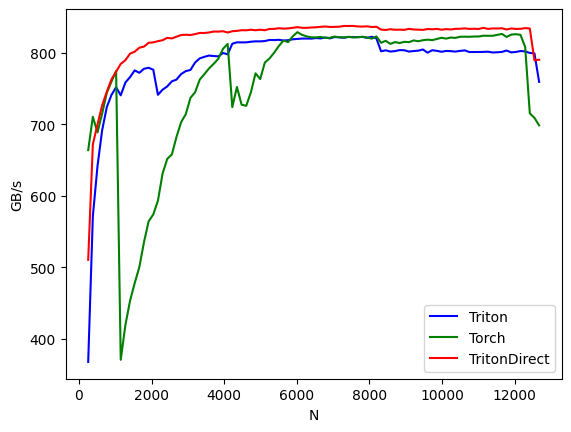

softmax-performance:
          N      Triton       Torch  TritonDirect
0     256.0  367.534126  663.824863    510.347192
1     384.0  571.451533  710.472827    671.902666
2     512.0  641.345868  688.707041    699.634427
3     640.0  691.598898  714.825813    726.536609
4     768.0  723.948420  743.919950    745.453822
5     896.0  740.981643  759.581373    762.744796
6    1024.0  751.723388  774.566044    773.461660
7    1152.0  740.513432  370.517196    784.451641
8    1280.0  758.453266  419.041723    789.572278
9    1408.0  765.957099  452.998324    798.765858
10   1536.0  775.349525  477.704028    801.524532
11   1664.0  772.006612  500.169863    807.071340
12   1792.0  777.615715  535.083202    808.631410
13   1920.0  779.024068  564.166032    813.966311
14   2048.0  776.321474  573.851189    814.581367
15   2176.0  741.197657  593.024530    816.259744
16   2304.0  748.373554  631.029677    817.604307
17   2432.0  752.956507  651.523552    820.860089
18   2560.0  760.039374  657.

In [104]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch', 'tritonDirect'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
            "TritonDirect"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    if provider == 'tritonDirect':
        ms = triton.testing.do_bench(lambda: softmax_direct(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)